In [ ]:
!nvidia-smi

Mon Sep  4 09:09:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### imports

In [ ]:
import glob
import shutil
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import PIL

### create necessary files

In [ ]:
base_dir = os.path.join('fresh_or_rotten')

train_dir = os.path.join(base_dir, 'train')
train_img_dir = os.path.join(train_dir, 'images')
train_label_dir = os.path.join(train_dir, 'labels')

test_dir = os.path.join(base_dir, 'test')
test_img_dir = os.path.join(test_dir, 'images')
test_label_dir = os.path.join(test_dir, 'labels')

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [ ]:
create_dir(base_dir)

create_dir(train_dir)
create_dir(train_img_dir)
create_dir(train_label_dir)

create_dir(test_dir)
create_dir(test_img_dir)
create_dir(test_label_dir)

### visualize the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gauthamsreedhar","key":"08d6ad2995f138c5896a8cfd62ef953c"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -lha kaggle.json


-rw-r--r-- 1 root root 71 Sep  4 08:44 kaggle.json


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

100% 3.58G/3.58G [03:03<00:00, 22.7MB/s]
100% 3.58G/3.58G [03:03<00:00, 21.0MB/s]


In [ ]:
!unzip fruits-fresh-and-rotten-for-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.09 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.18 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.24 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.37 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.51 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.02 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.12 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.21 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.31 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07

In [ ]:
dataset_path = '/content/dataset/dataset'

In [ ]:
fruit_count=[]
fruit_name=[]
for i in os.listdir(dataset_path+'/train'):
    fruit_name.append(i)
    fruit_count.append(len(os.listdir(os.path.join(dataset_path+'/train', i))))

In [ ]:
fruit_df = pd.DataFrame({'fruit_name':fruit_name, 'fruit_count':fruit_count})

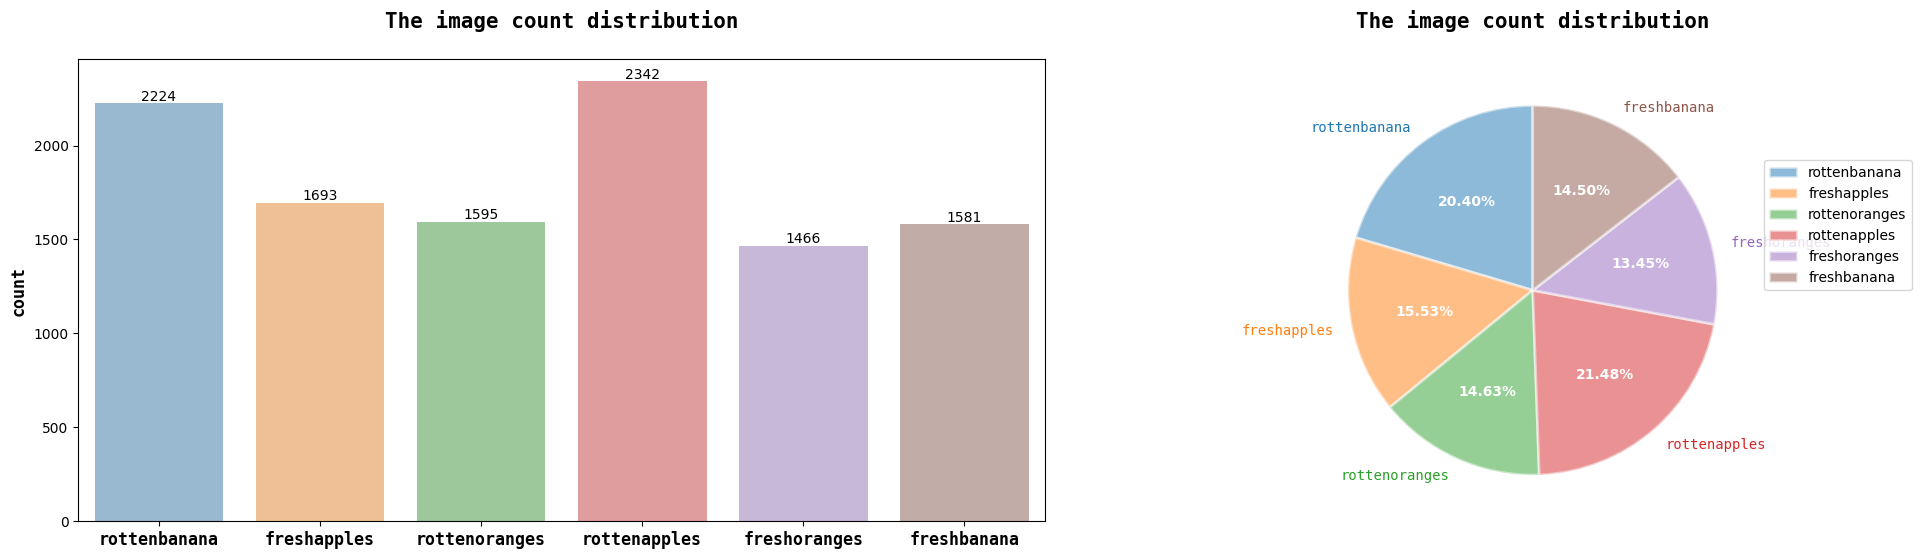

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(25,6), gridspec_kw=dict(wspace=0.005))
sns.barplot(data=fruit_df, x='fruit_name', y='fruit_count',ax=axes[0], alpha=0.5)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)

axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15)

patches, texts, pcts = axes[1].pie(fruit_df['fruit_count'], labels=fruit_df['fruit_name'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1,0.5])
axes[1].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15);

### create yolo required dataframe

In [ ]:
def get_image_range(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 0], dtype = "uint8")
    upper = np.array([255, 50, 255], dtype = "uint8")
    img = cv2.inRange(img, lower, upper)
    img = cv2.blur(img, (2, 2))
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    img = cv2.bitwise_not(thresh)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = max(contours, key=lambda x: cv2.contourArea(x))

    #get bounding box posotion
    xmin, ymin, xmax, ymax = cv2.boundingRect(contours)

    #get the original width,height of the image
    dimensions = img.shape
    h = img.shape[0]
    w = img.shape[1]

    #to calculate the bndBox info of this image for yolo
    xp = (xmin + (xmax-xmin)/2) * 1.0 / w
    yp = (ymin + (ymax-ymin)/2) * 1.0 / h
    wp = (xmax-xmin) * 1.0 / w
    hp = (ymax-ymin) * 1.0 / h
    return xp, yp, wp, hp

In [ ]:
for dirname, _, filenames in os.walk(dataset_path):
    if dirname[1:].split('/')[-2]=='train':
        for img_path in glob.glob(dirname+'/*.png'):
            shutil.copy(img_path, os.path.join(train_img_dir, img_path.split('/')[-1]))
            label=0
            if img_path.split('/')[-2] == 'freshapples':
                label=0
            elif img_path.split('/')[-2] == 'freshbanana':
                label=1
            elif img_path.split('/')[-2] == 'freshoranges':
                label=2
            elif img_path.split('/')[-2] == 'rottenapples':
                label=3
            elif img_path.split('/')[-2] == 'rottenbanana':
                label=4
            elif img_path.split('/')[-2] == 'rottenoranges':
                label=5
            x_center, y_center, box_width, box_height = get_image_range(img_path)
            text = str(label)+' '+str(x_center)+' '+str(y_center)+' '+str(box_width)+' '+str(box_height)
            with open (os.path.join(train_label_dir, img_path.split('/')[-1][:-4]+'.txt'),'w') as file:
                file.write(text)

    if dirname[1:].split('/')[-2]=='test':
        for img_path in glob.glob(dirname+'/*.png'):
            shutil.copy(img_path, os.path.join(test_img_dir, img_path.split('/')[-1]))
            label=0
            if img_path.split('/')[-2] == 'freshapples':
                label=0
            elif img_path.split('/')[-2] == 'freshbanana':
                label=1
            elif img_path.split('/')[-2] == 'freshoranges':
                label=2
            elif img_path.split('/')[-2] == 'rottenapples':
                label=3
            elif img_path.split('/')[-2] == 'rottenbanana':
                label=4
            elif img_path.split('/')[-2] == 'rottenoranges':
                label=5
            x_center, y_center, box_width, box_height = get_image_range(img_path)
            text = str(label)+' '+str(x_center)+' '+str(y_center)+' '+str(box_width)+' '+str(box_height)
            with open (os.path.join(test_label_dir, img_path.split('/')[-1][:-4]+'.txt'),'w') as file:
                file.write(text)

In [ ]:
print(f'There are {len(os.listdir(train_img_dir))} train images')
print(f'There are {len(os.listdir(train_label_dir))} corresponding train labels\n')

print(f'There are {len(os.listdir(test_img_dir))} train images')
print(f'There are {len(os.listdir(test_label_dir))} corresponding test labels')

There are 10901 train images
There are 10901 corresponding train labels

There are 2698 train images
There are 2698 corresponding test labels


In [ ]:
df = pd.DataFrame({'file':['train', 'test'], 'count':[len(os.listdir(train_img_dir)),len(os.listdir(test_img_dir))]})

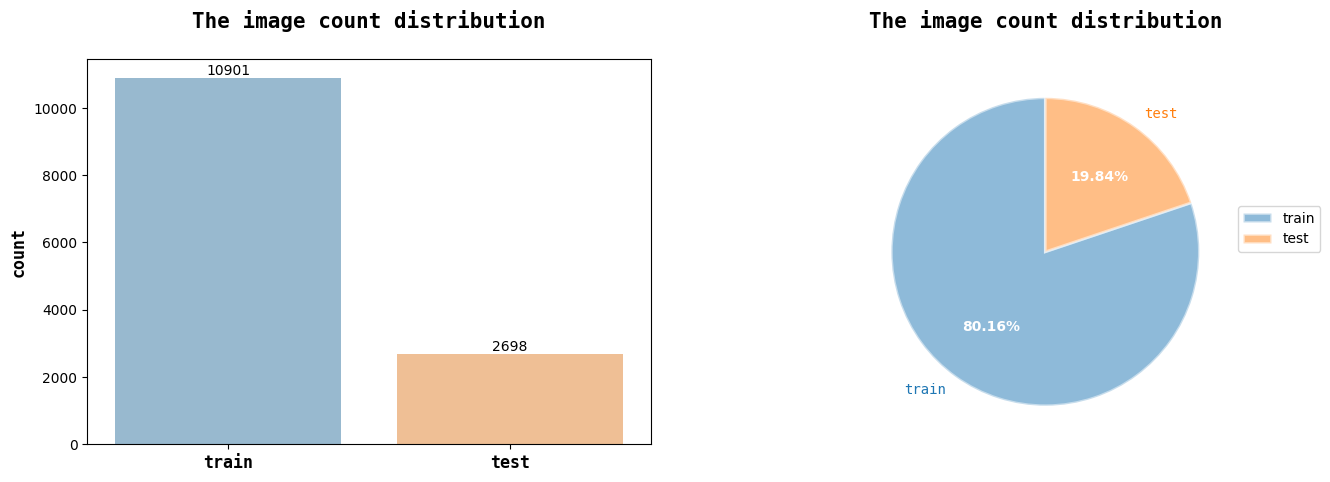

In [ ]:

fig,axes = plt.subplots(1,2,figsize=(16,5))
sns.barplot(data=df.reset_index(), x='file', y='count',ax=axes[0], alpha=0.5)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)

axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15)

patches, texts, pcts = axes[1].pie(df['count'], labels=df['file'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1,0.5])
axes[1].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15);

### remove some files

In [ ]:
for path in os.listdir(train_img_dir):
    if 'translation' in path:
        os.remove(os.path.join(train_img_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(train_img_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(train_img_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(train_img_dir, path))
# after many tests, I realized that images with these key words were not properly annotated

In [ ]:
for path in os.listdir(test_img_dir):
    if 'translation' in path:
        os.remove(os.path.join(test_img_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(test_img_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(test_img_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(test_img_dir, path))

In [ ]:
for path in os.listdir(train_label_dir):
    if 'translation' in path:
        os.remove(os.path.join(train_label_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(train_label_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(train_label_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(train_label_dir, path))

In [ ]:
for path in os.listdir(test_label_dir):
    if 'translation' in path:
        os.remove(os.path.join(test_label_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(test_label_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(test_label_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(test_label_dir, path))

In [ ]:
plan_to_delete_from_train = random.sample([i for i in os.listdir(train_img_dir)], 550)
plan_to_delete_from_test = random.sample([i for i in os.listdir(test_img_dir)], 230)

In [ ]:
for i in plan_to_delete_from_train:
    os.remove(os.path.join(train_img_dir, i))
    os.remove(os.path.join(train_label_dir, i[:-4]+'.txt'))

In [ ]:
for i in plan_to_delete_from_test:
    os.remove(os.path.join(test_img_dir, i))
    os.remove(os.path.join(test_label_dir, i[:-4]+'.txt'))

In [ ]:
print(f'There are {len(os.listdir(train_img_dir))} train images')
print(f'There are {len(os.listdir(train_label_dir))} corresponding train labels\n')

print(f'There are {len(os.listdir(test_img_dir))} train images')
print(f'There are {len(os.listdir(test_label_dir))} corresponding test labels')

There are 632 train images
There are 632 corresponding train labels

There are 99 train images
There are 99 corresponding test labels


### see the images

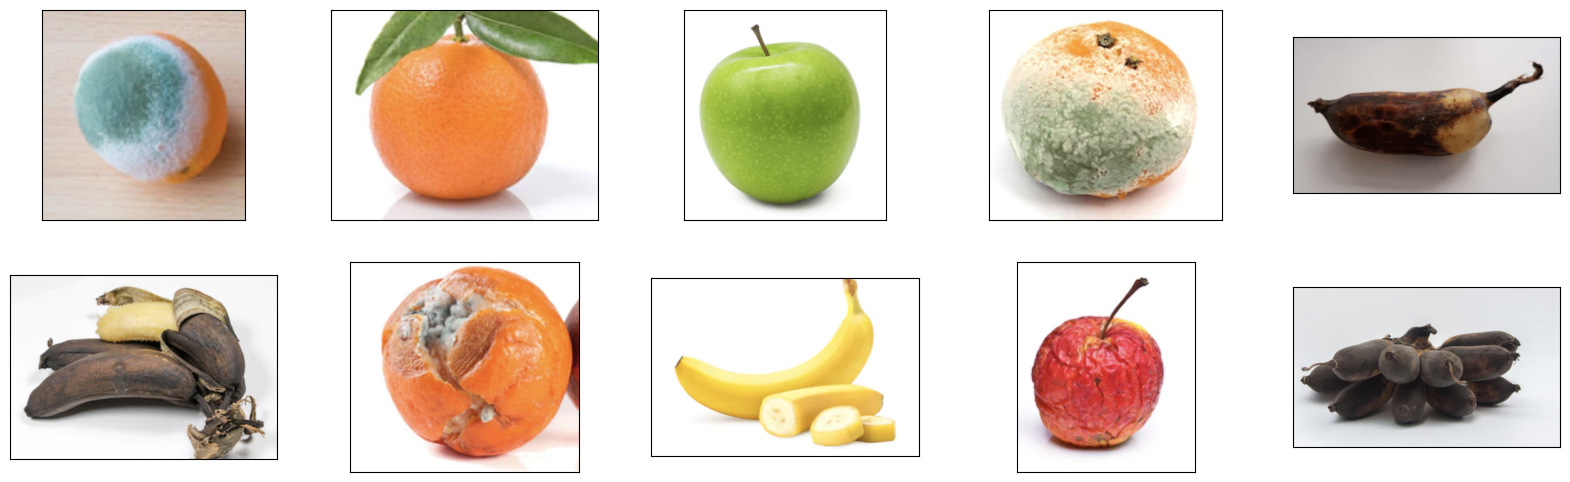

In [ ]:
img_path=[]
selected_img = random.sample([i for i in os.listdir(train_img_dir)], 10)
for i in selected_img:
    img_path.append(os.path.join(train_img_dir, i))


fig, axes = plt.subplots(2,5, figsize=(20,6), subplot_kw=dict(xticks=[], yticks=[]))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.array(PIL.Image.open(img_path[i])))

### create the yaml file for yolo

In [ ]:
yaml_file = """names:
- fresh_apples
- fresh_banana
- fresh_oranges
- rotten_apples
- rotten_banana
- rotten_oranges
nc: 6
train: /content/fresh_or_rotten/train/images
val: /content/fresh_or_rotten/test/images
"""

with open('/content/fresh_or_rotten/data.yaml', 'w') as f:
    f.write(yaml_file)

In [ ]:
with open(os.path.join(train_label_dir, os.listdir(train_label_dir)[0]),'r') as f:
    c = f.read()
    print(c)

0 0.4724576271186441 0.47294372294372294 0.8305084745762712 0.8593073593073594


### train yolo model

In [ ]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 7.3 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output
! yolo checks

/usr/local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Ultralytics YOLOv8.0.170 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.9/78.2 GB disk)


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [ ]:
!conda install pytorch torchvision torchaudio -c pytorch

| / - \ | / - \ | / - \ | / - done
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / failed with initial froz

In [ ]:
! yolo task=detect mode=train model=yolov8x.pt data=/content/fresh_or_rotten/data.yaml epochs=8 imgsz=640

100% 131M/131M [00:00<00:00, 192MB/s]
Ultralytics YOLOv8.0.170 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/fresh_or_rotten/data.yaml, epochs=8, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes

### see the results

In [ ]:
os.listdir('/content/runs/detect/train')

['train_batch0.jpg',
 'train_batch1.jpg',
 'results.png',
 'labels_correlogram.jpg',
 'args.yaml',
 'events.out.tfevents.1693817988.22115d213488.8239.0',
 'train_batch2.jpg',
 'weights',
 'labels.jpg',
 'results.csv']

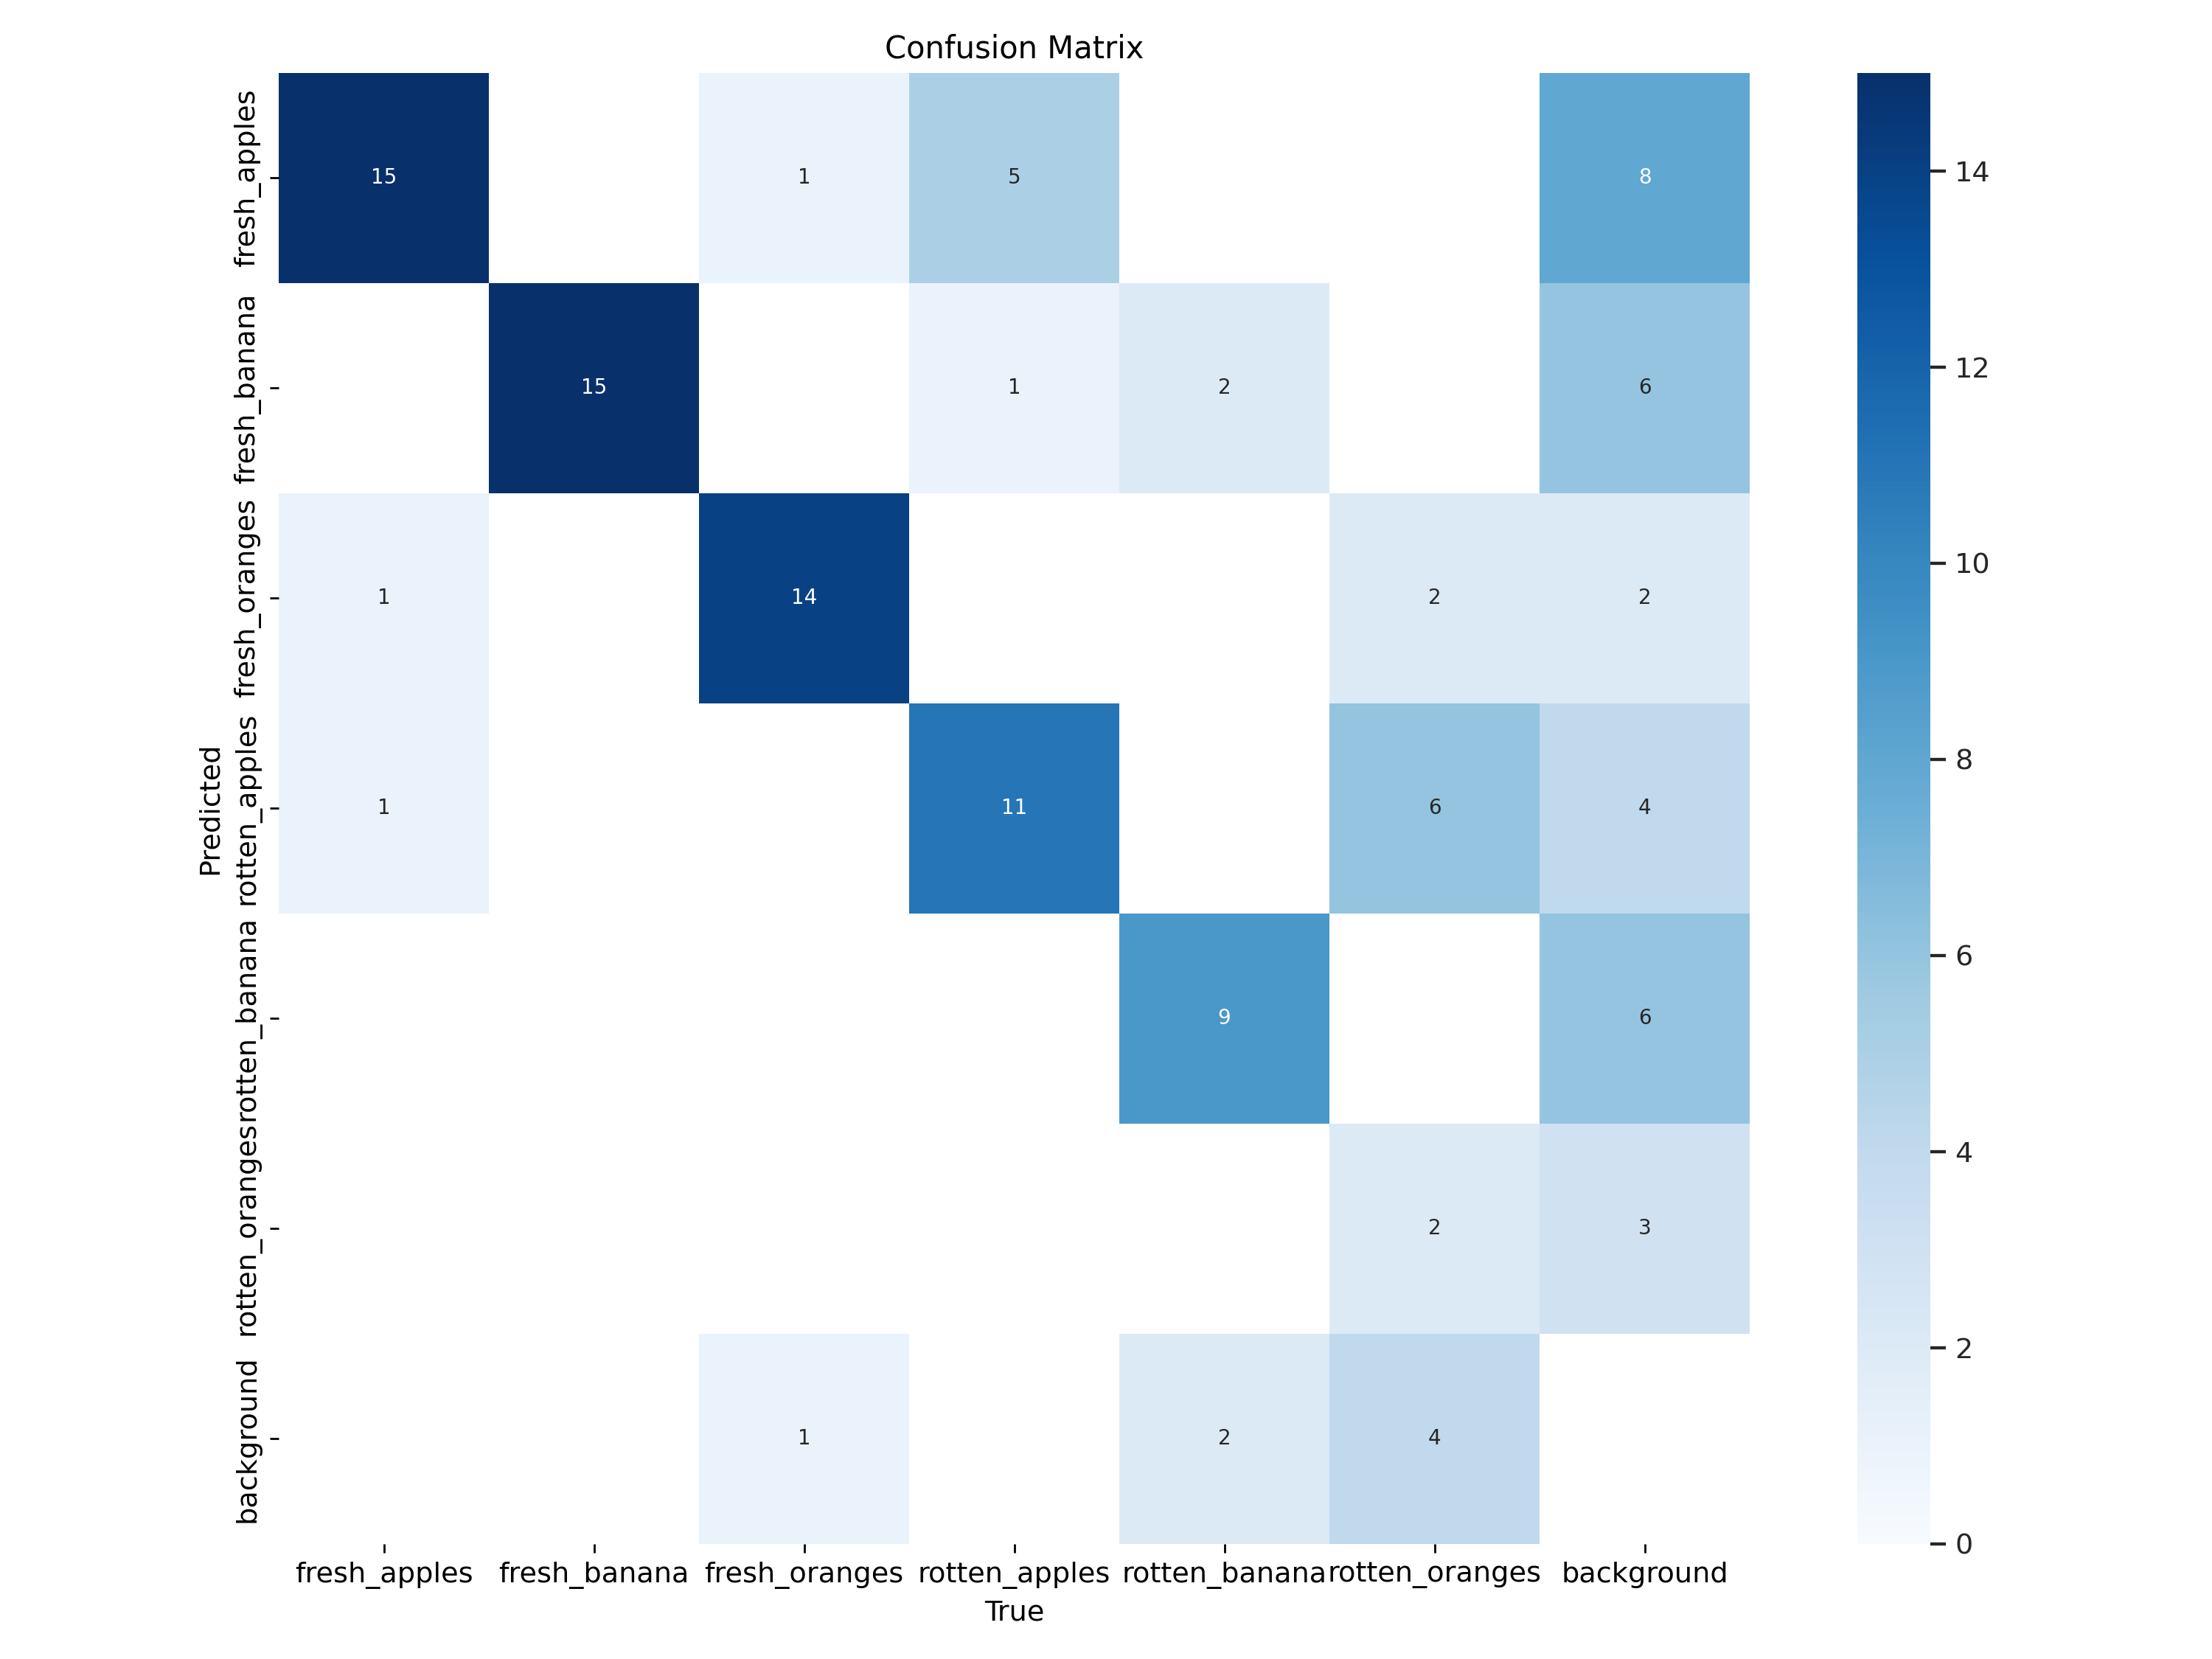

In [ ]:
Image('/content/runs/detect/train/confusion_matrix.png')

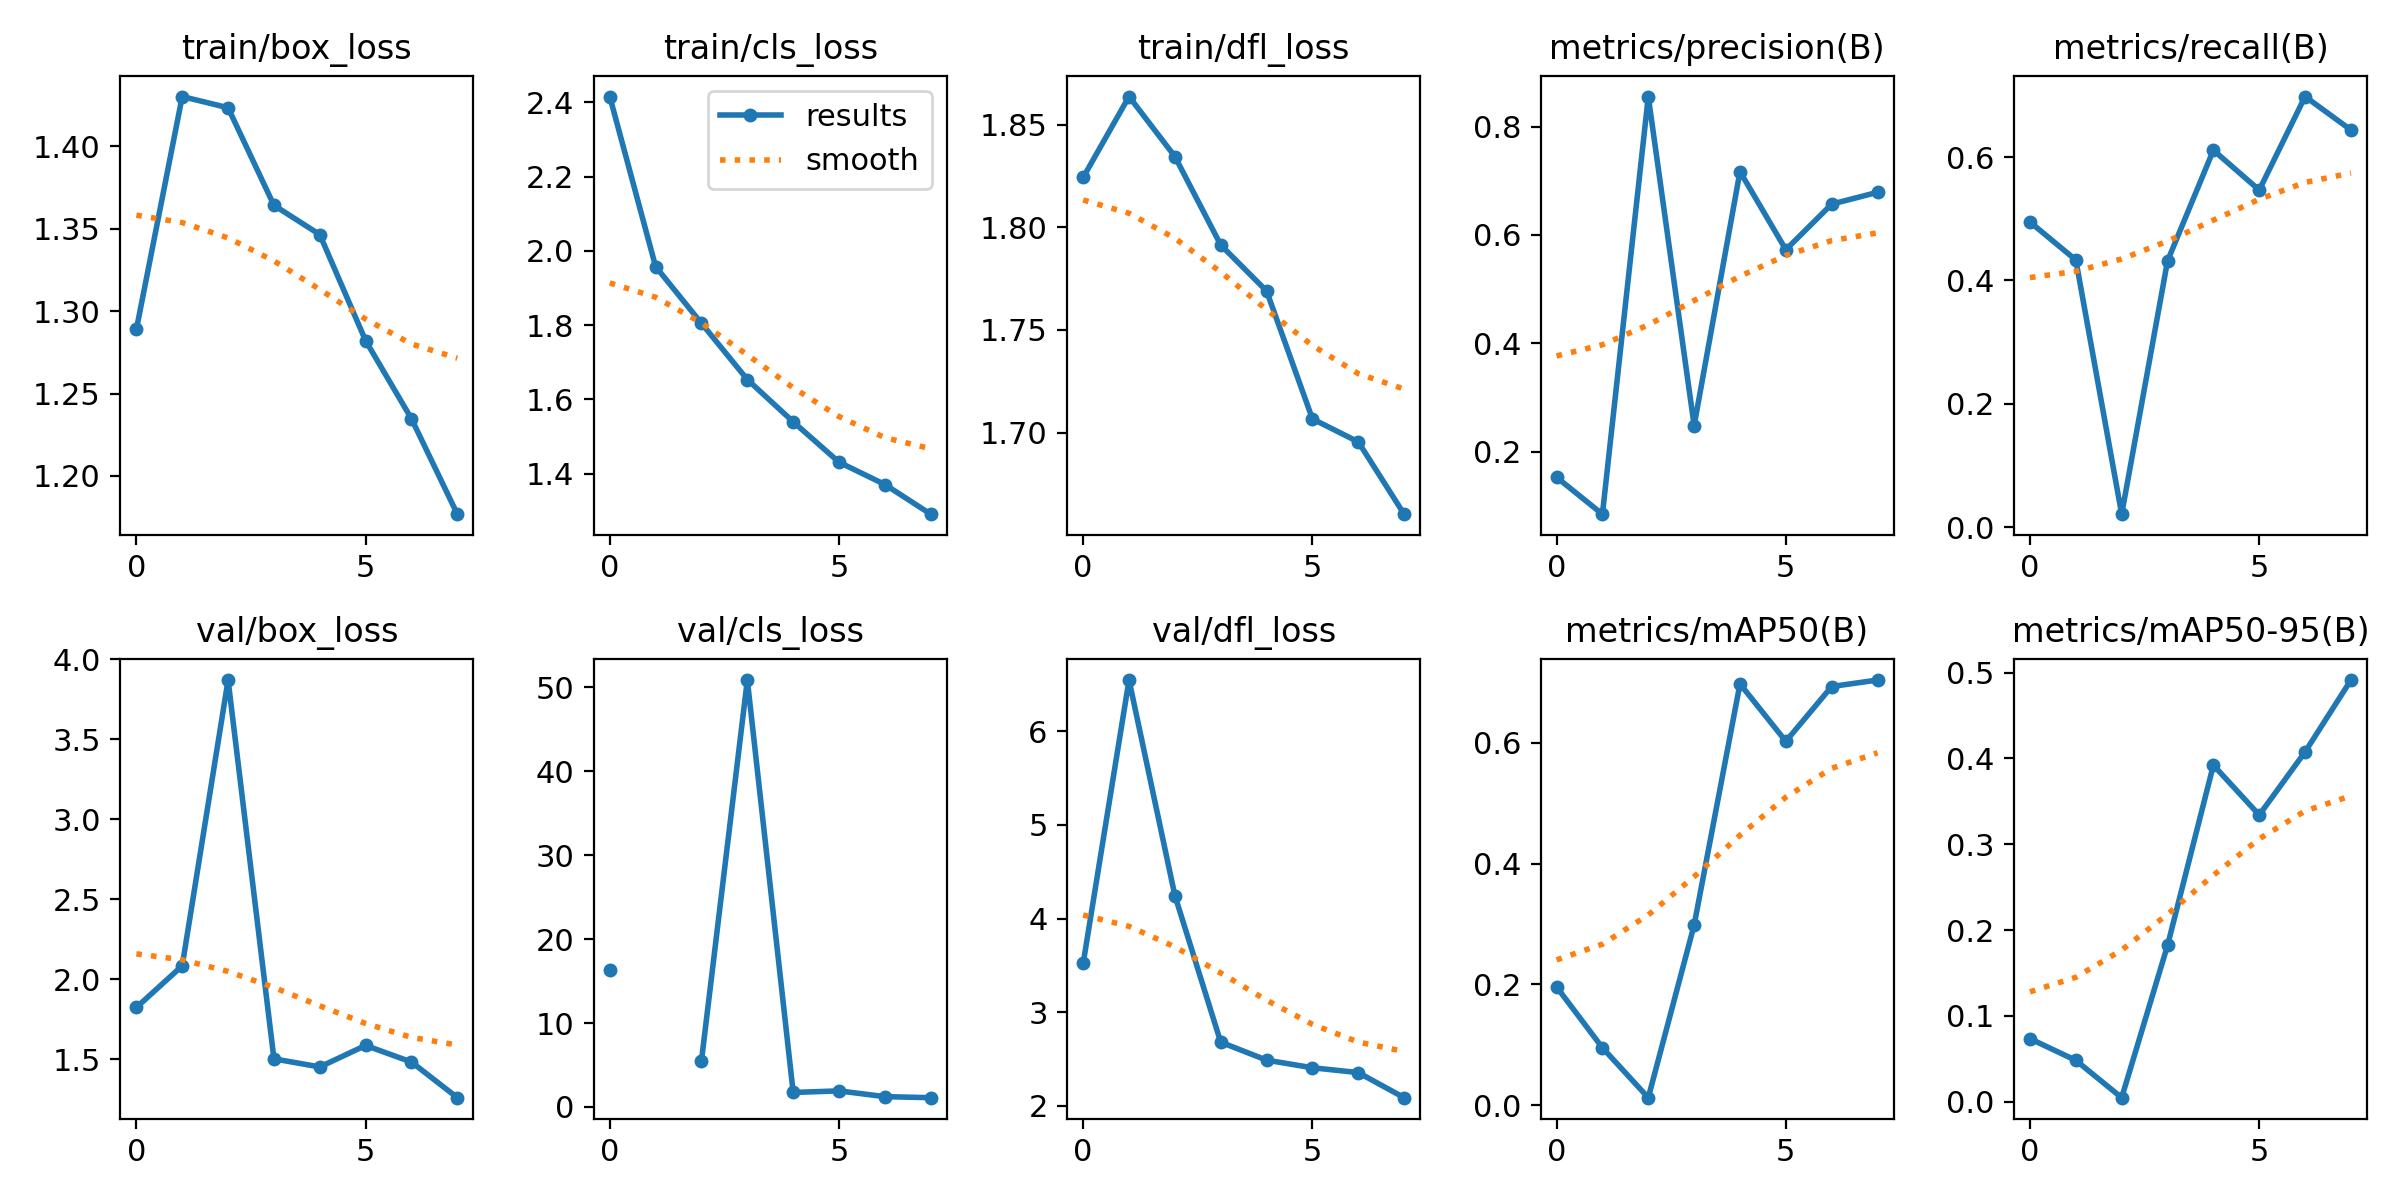

In [ ]:
Image('/content/runs/detect/train/results.png')

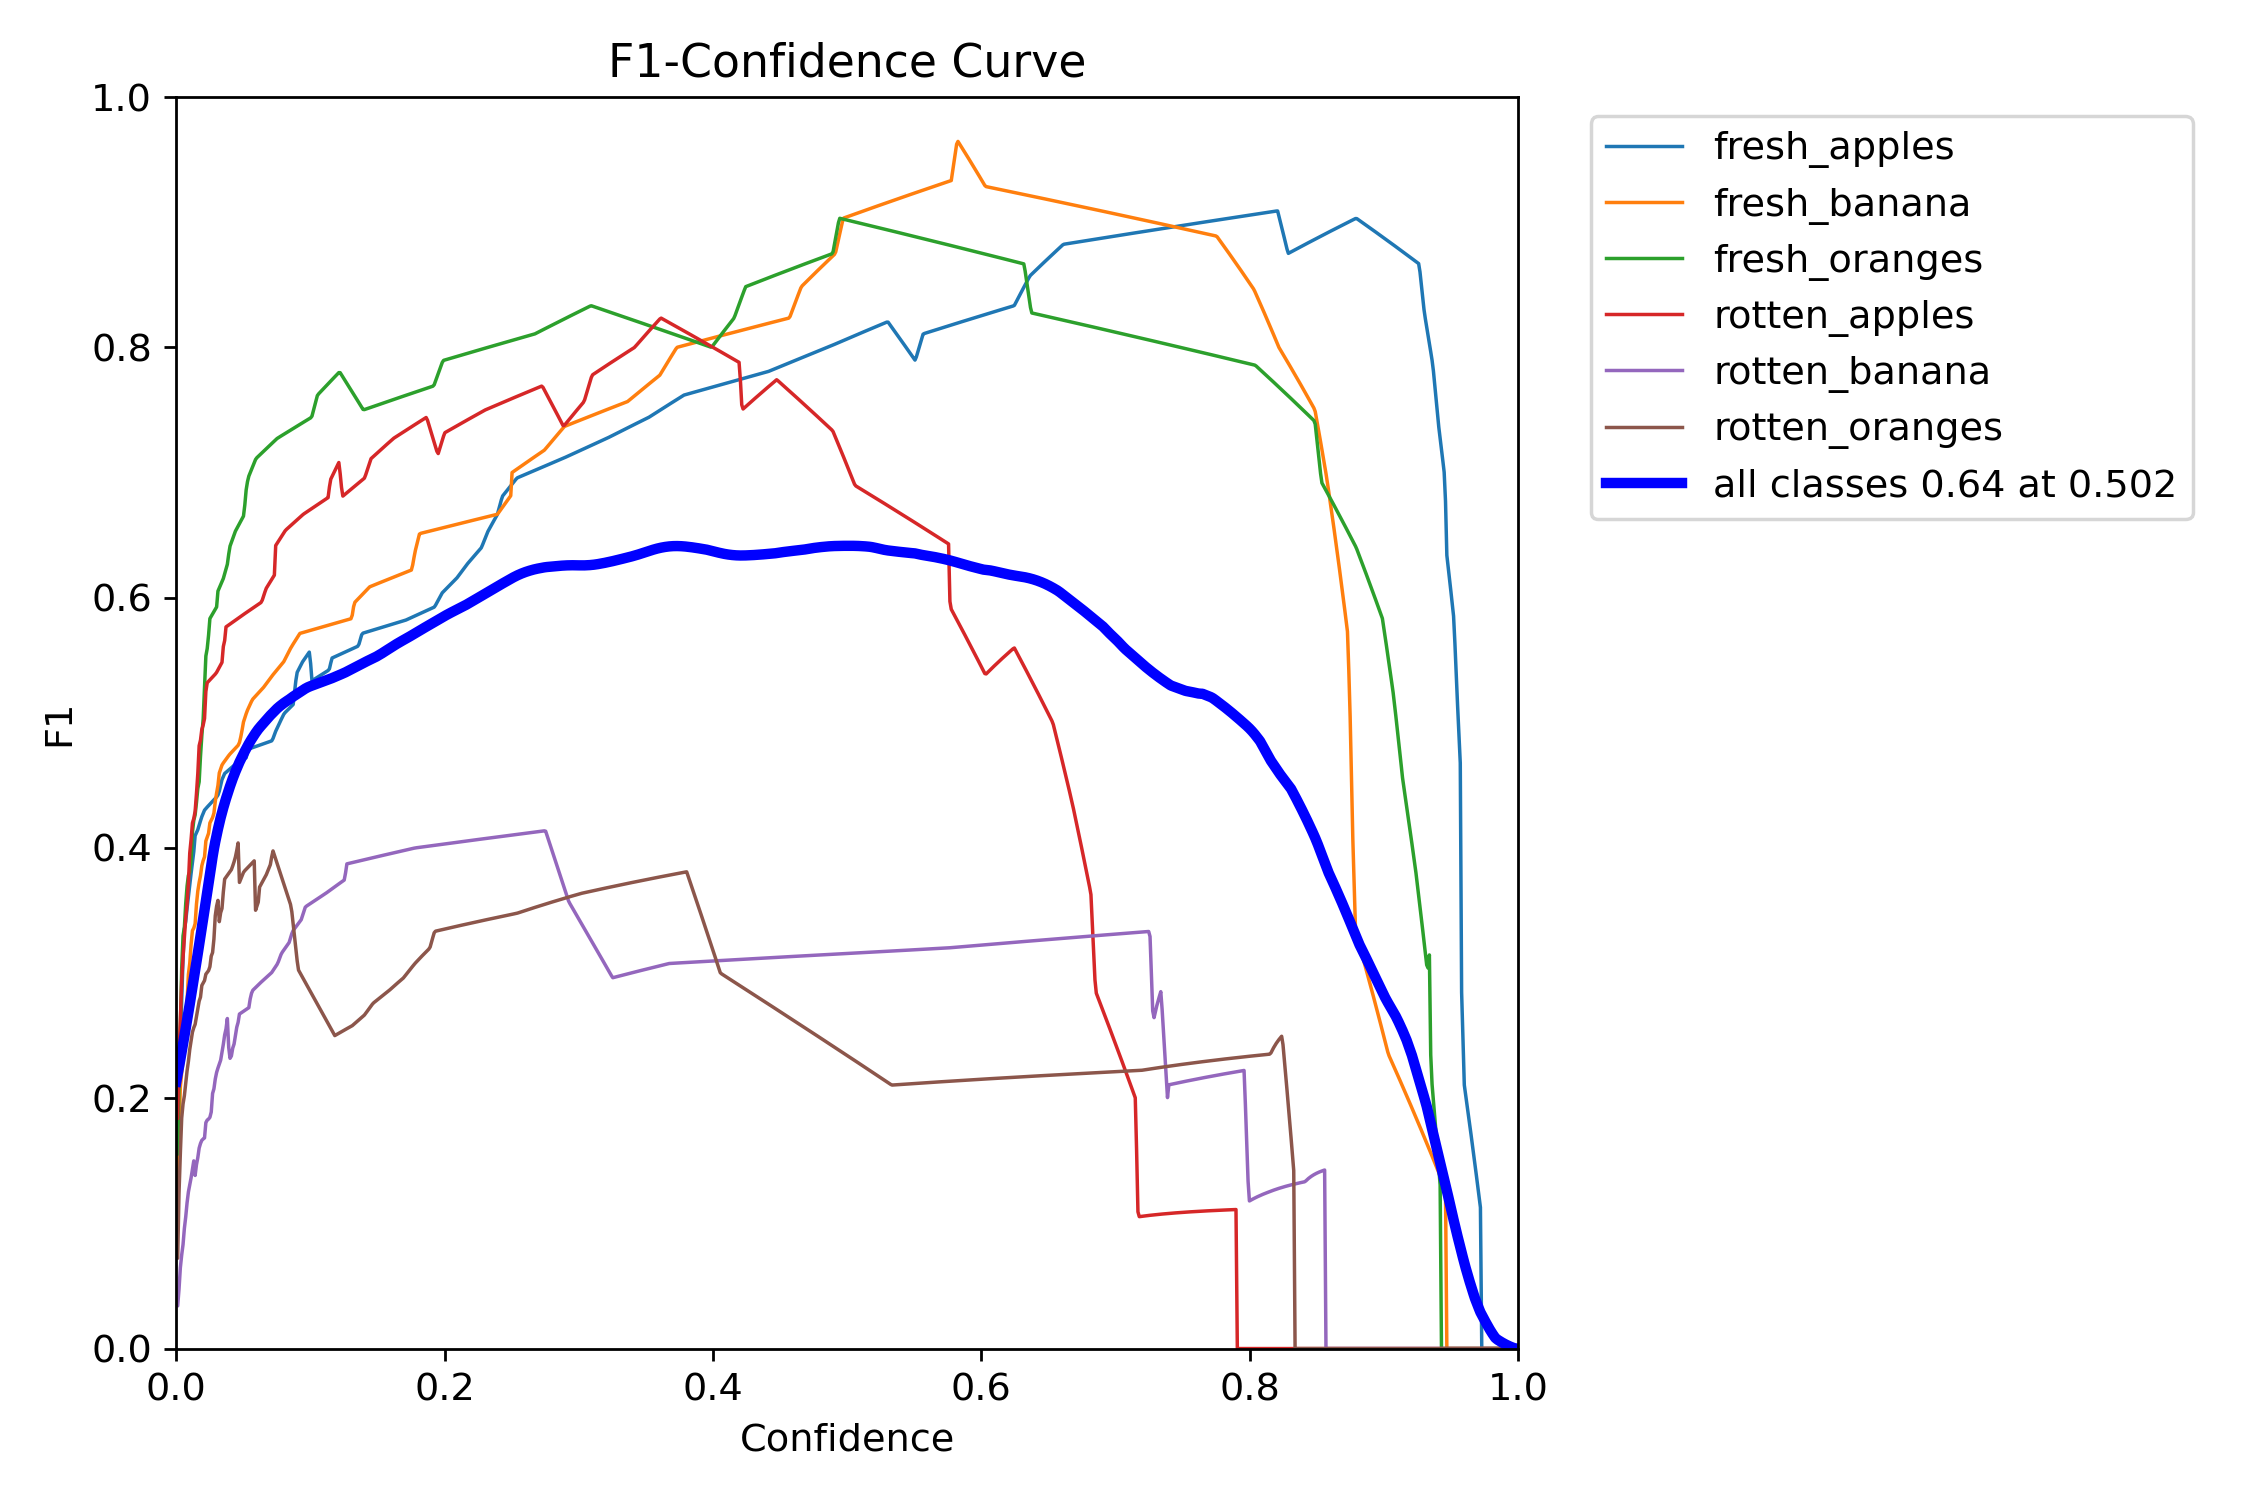

In [ ]:
Image(filename = '/content/runs/detect/train/F1_curve.png')

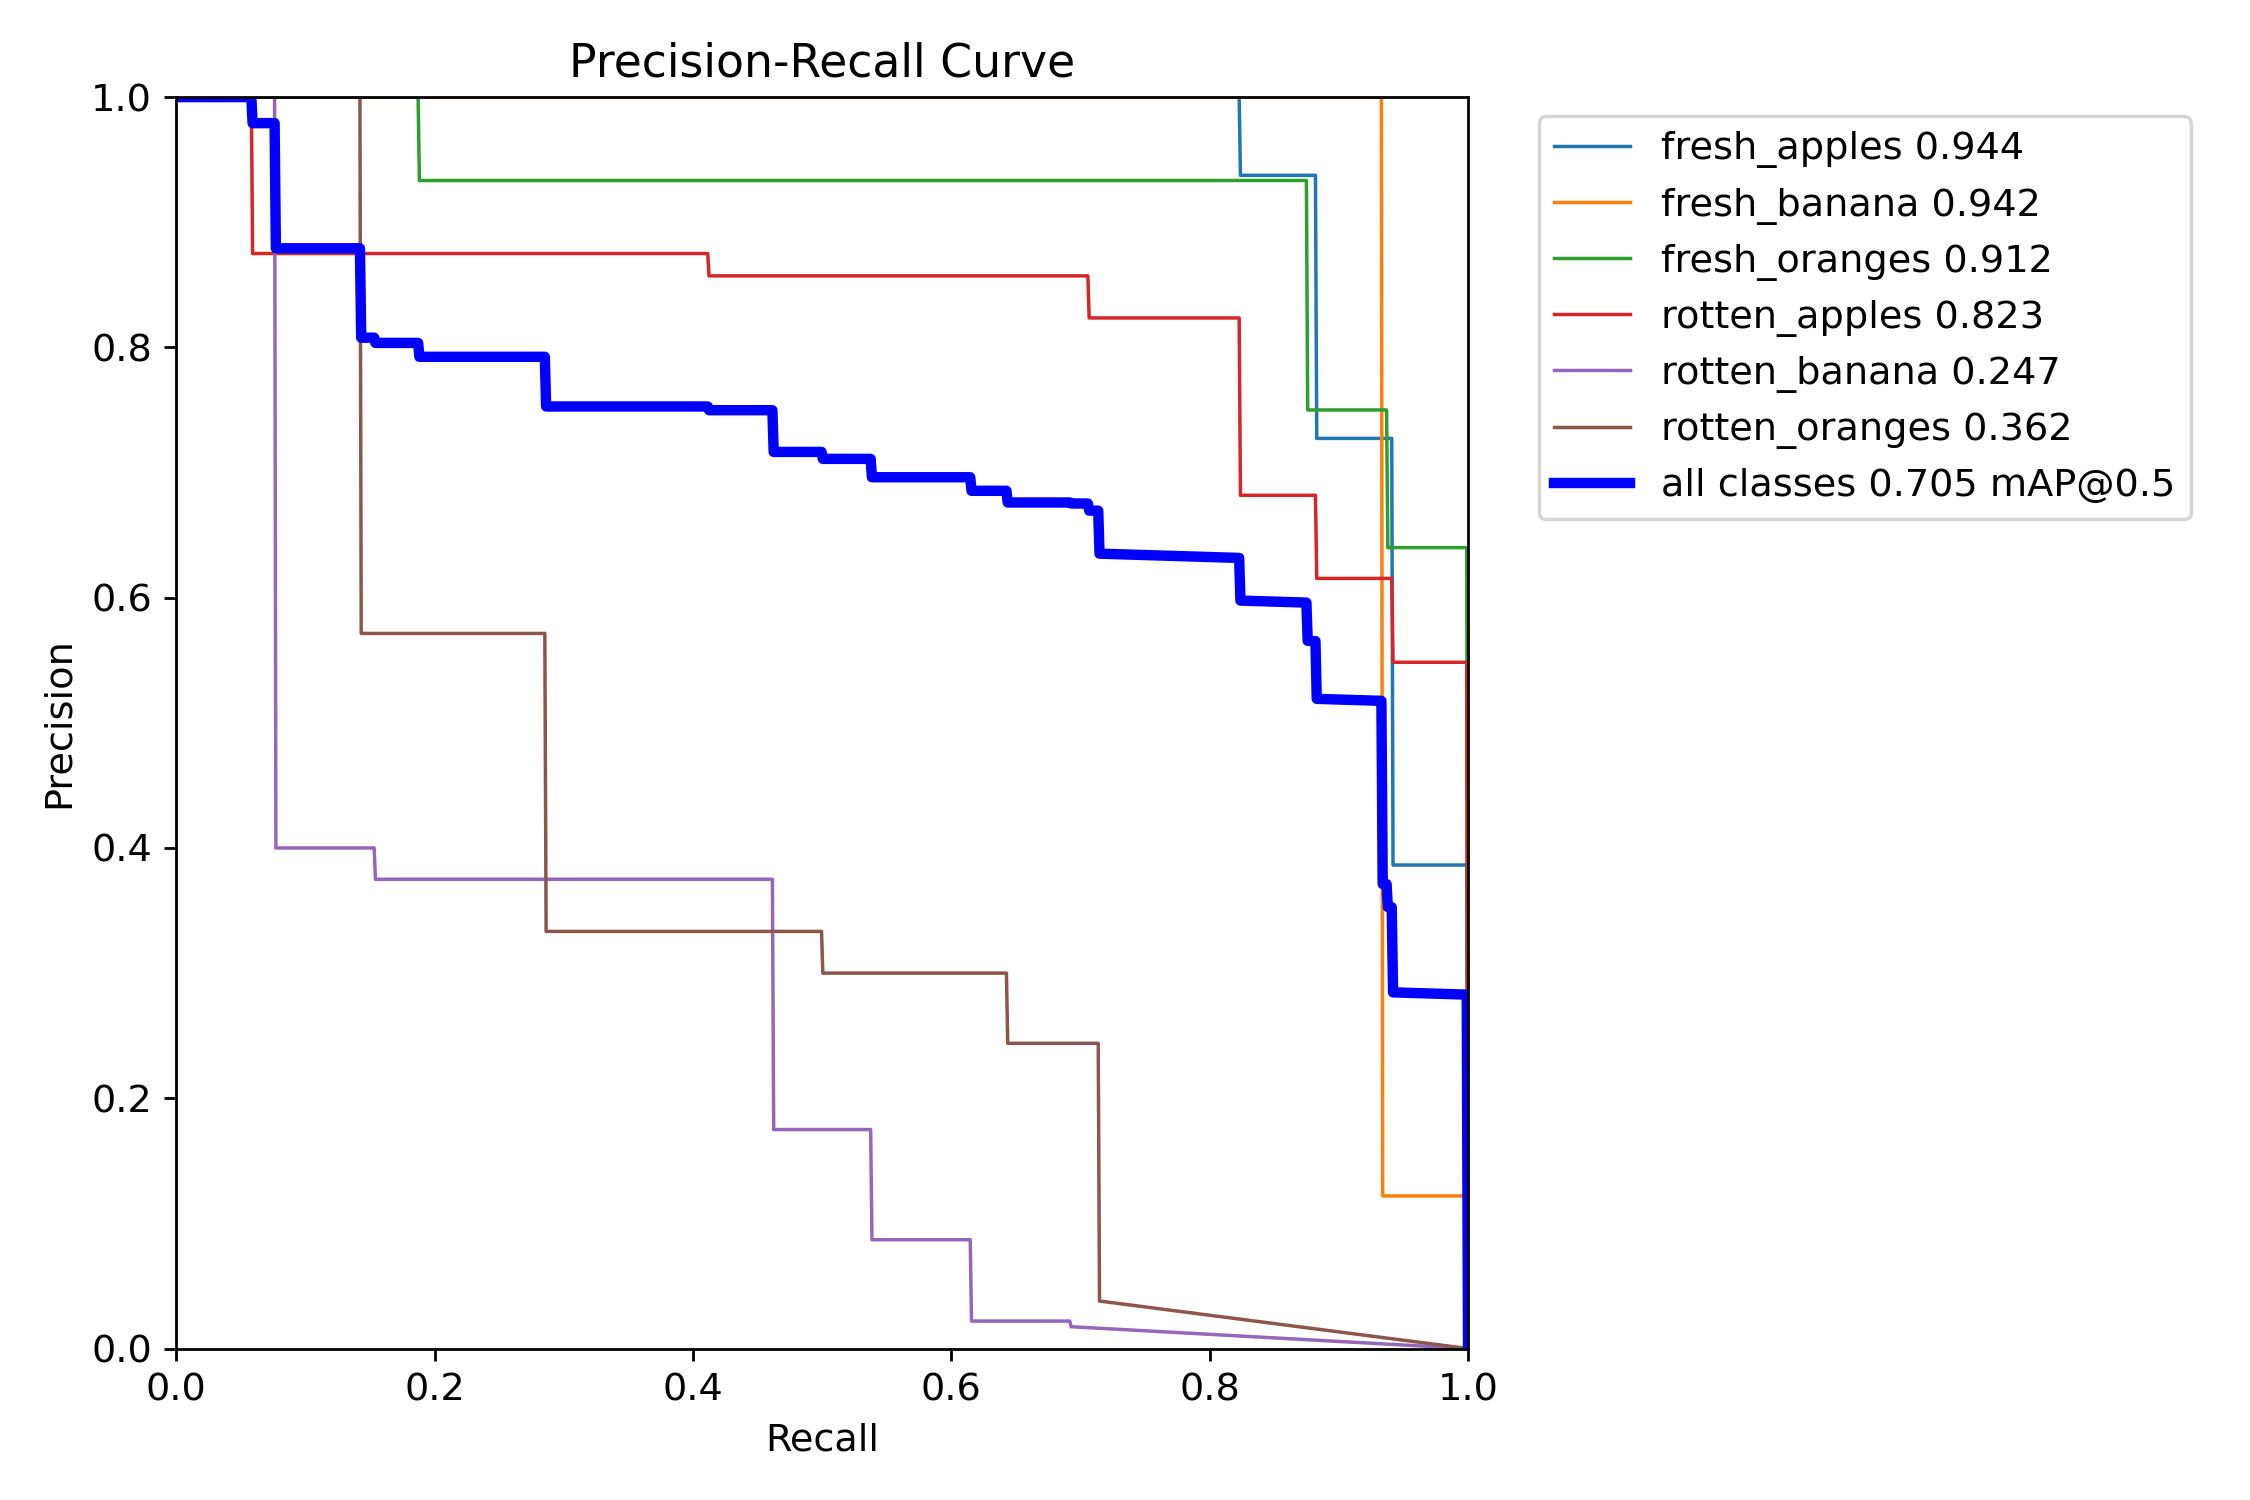

In [ ]:
Image(filename = '/content/runs/detect/train/PR_curve.png')

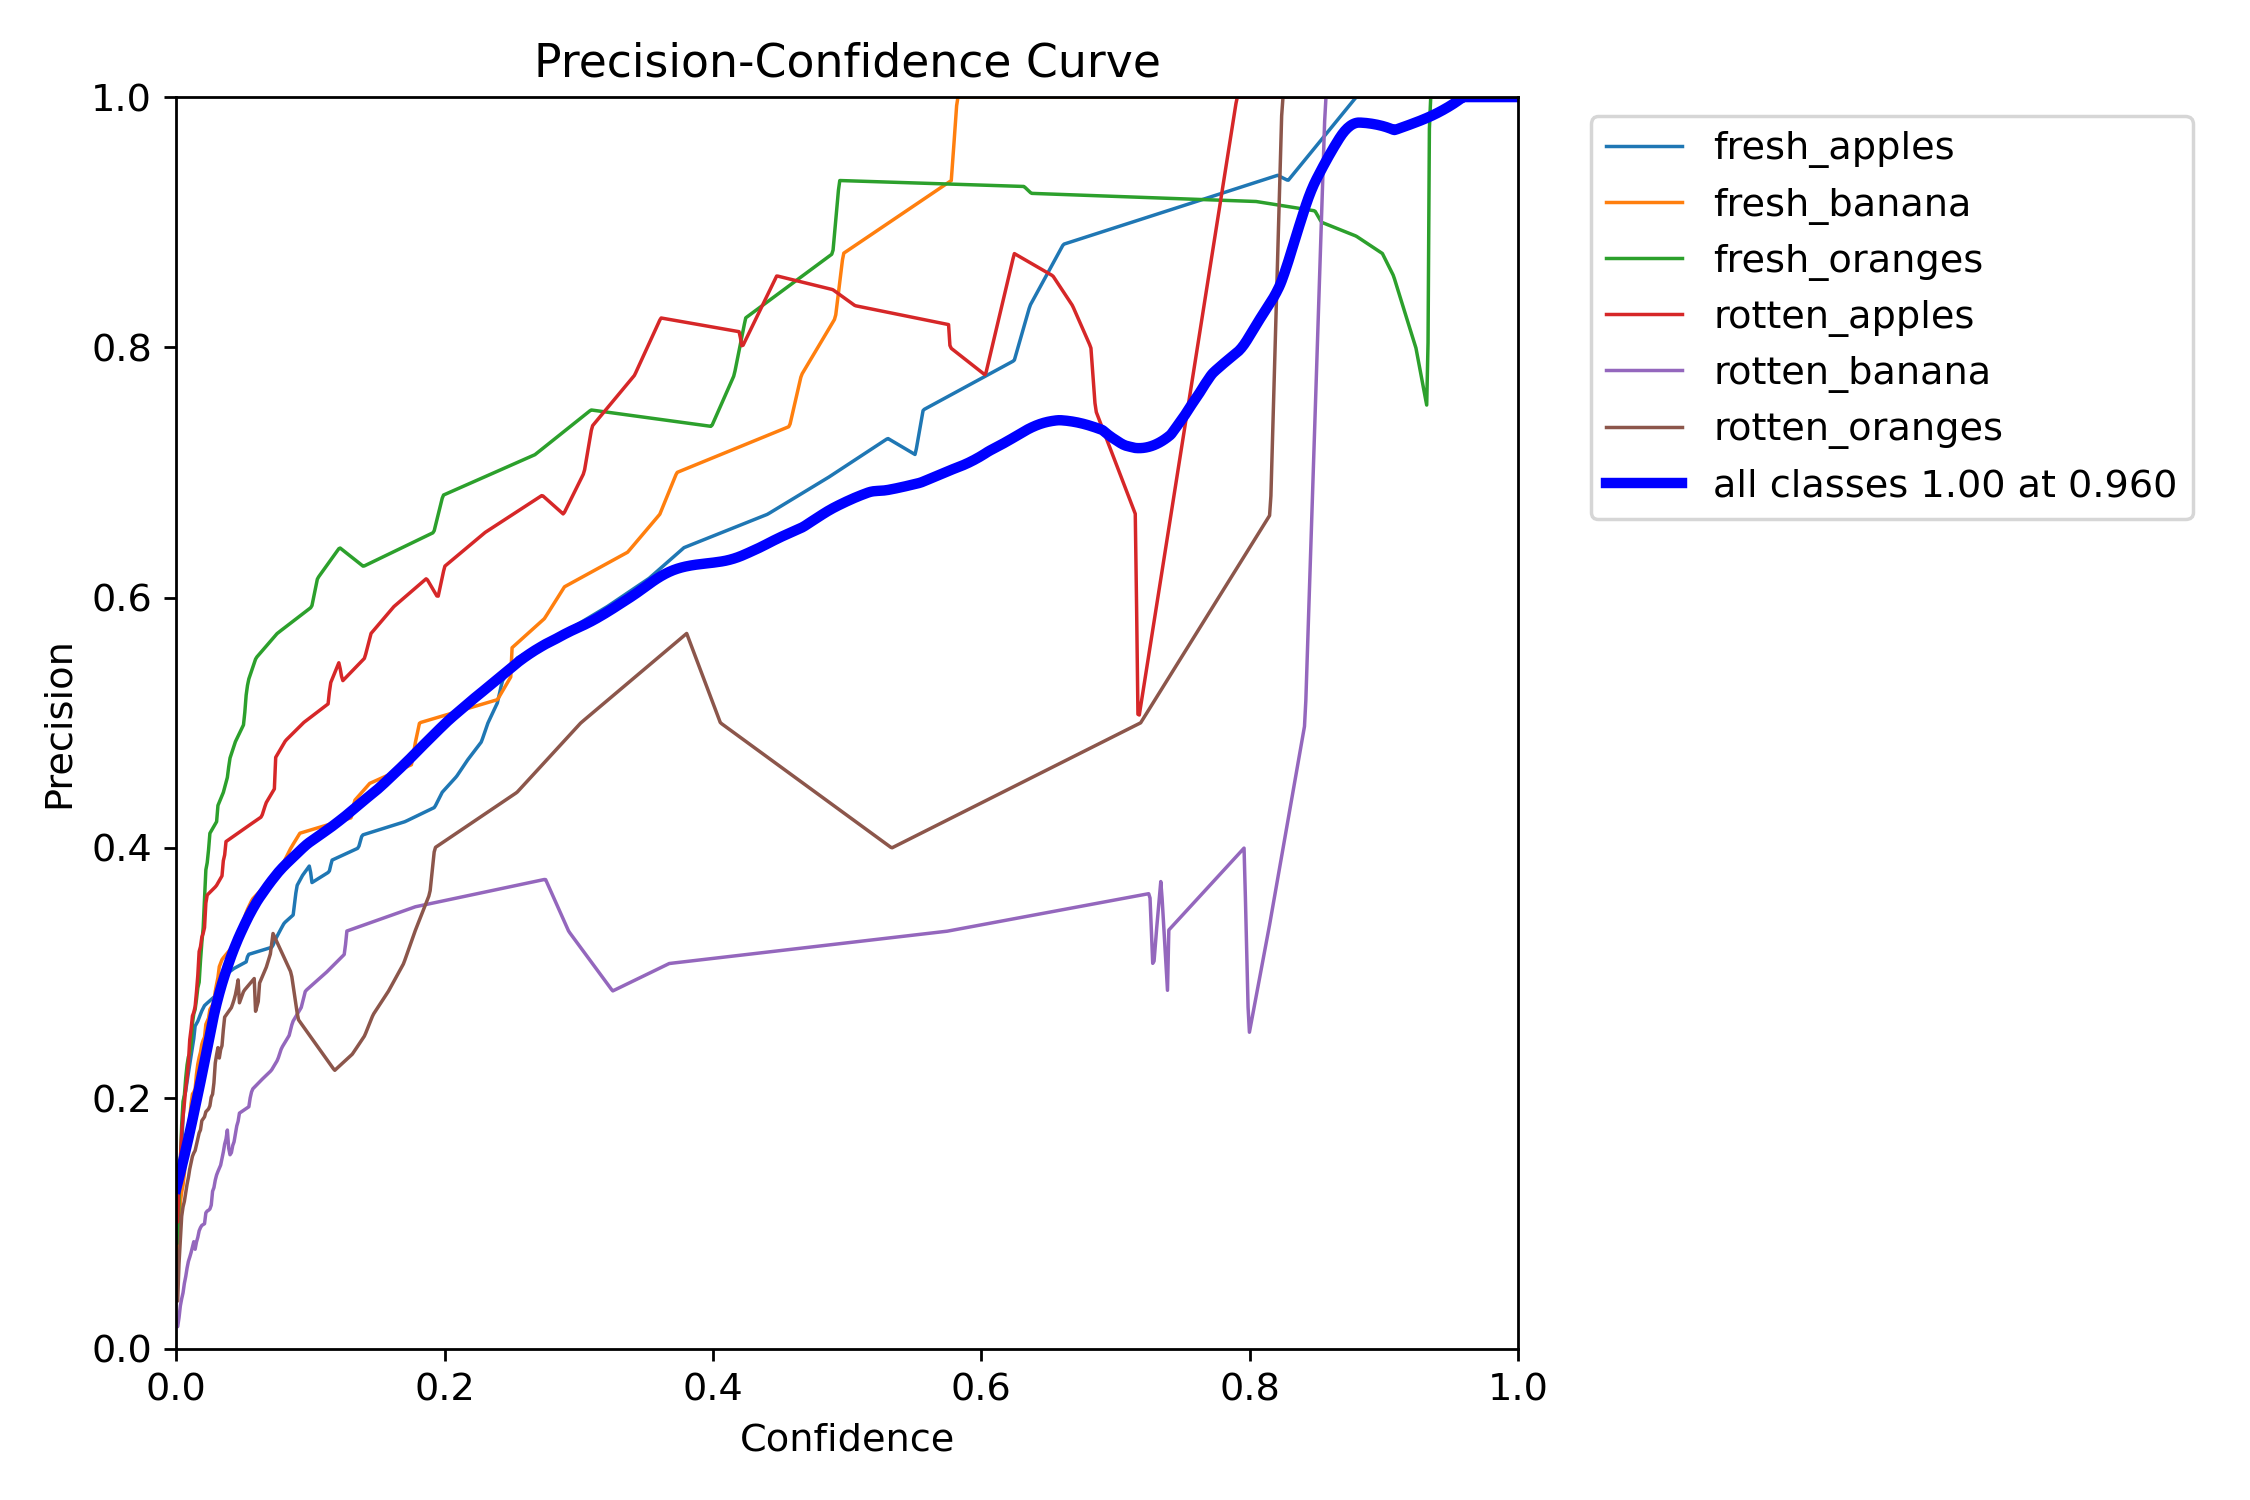

In [ ]:
Image(filename = '/content/runs/detect/train/P_curve.png')

In [ ]:
shutil.copy('/content/runs/detect/train/weights/best.pt','/content')

'/content/best.pt'

In [ ]:
! yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/fresh_or_rotten/data.yaml

Ultralytics YOLOv8.0.170 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68129346 parameters, 0 gradients
val: Scanning /content/fresh_or_rotten/test/labels.cache... 99 images, 0 backgrounds, 5 corrupt: 100% 99/99 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/fresh_or_rotten/test/images/Screen Shot 2018-06-12 at 11.18.34 PM.png: ignoring corrupt image/label: negative label values [     -0.125]
val: WARNING ⚠️ /content/fresh_or_rotten/test/images/Screen Shot 2018-06-12 at 8.52.16 PM.png: ignoring corrupt image/label: negative label values [   -0.27548]
val: WARNING ⚠️ /content/fresh_or_rotten/test/images/Screen Shot 2018-06-12 at 8.53.09 PM.png: ignoring corrupt image/label: negative label values [   -0.12088]
val: WARNING ⚠️ /content/fresh_or_rotten/test/images/Screen Shot 2018-06-12 at 9.03.34 PM.png: ignoring corrupt image/label: negative label values [   -0.24016]
val: WARNING ⚠️ /content/fresh_or_rotten/test/images/Screen Shot 2018-06-1

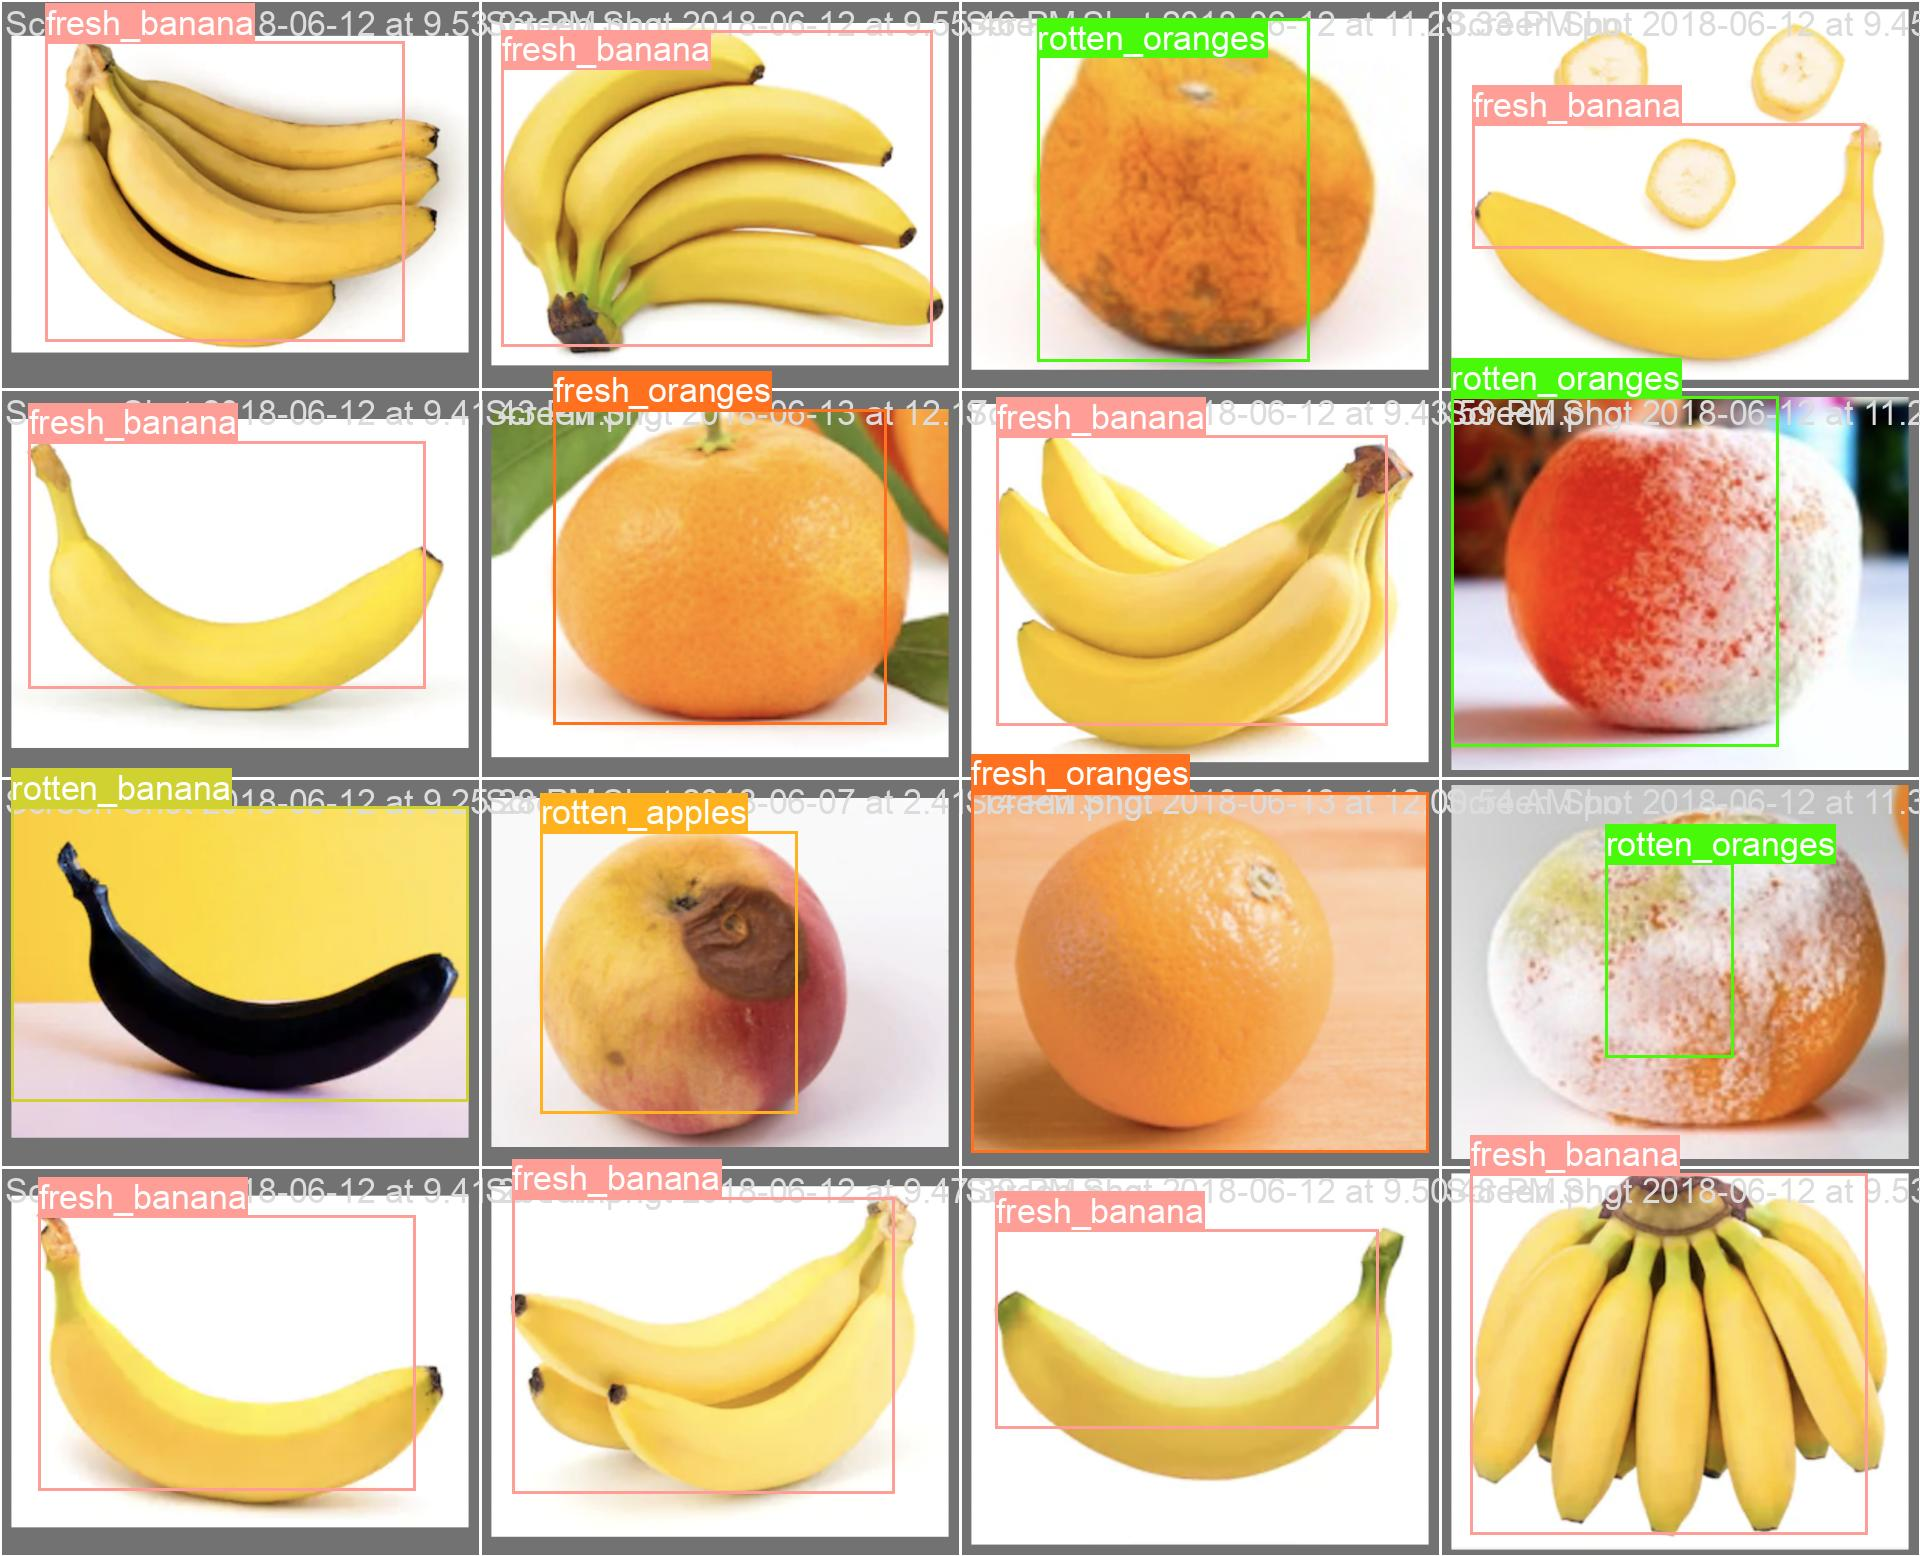

In [ ]:
Image(filename = '/content/runs/detect/val/val_batch1_labels.jpg')

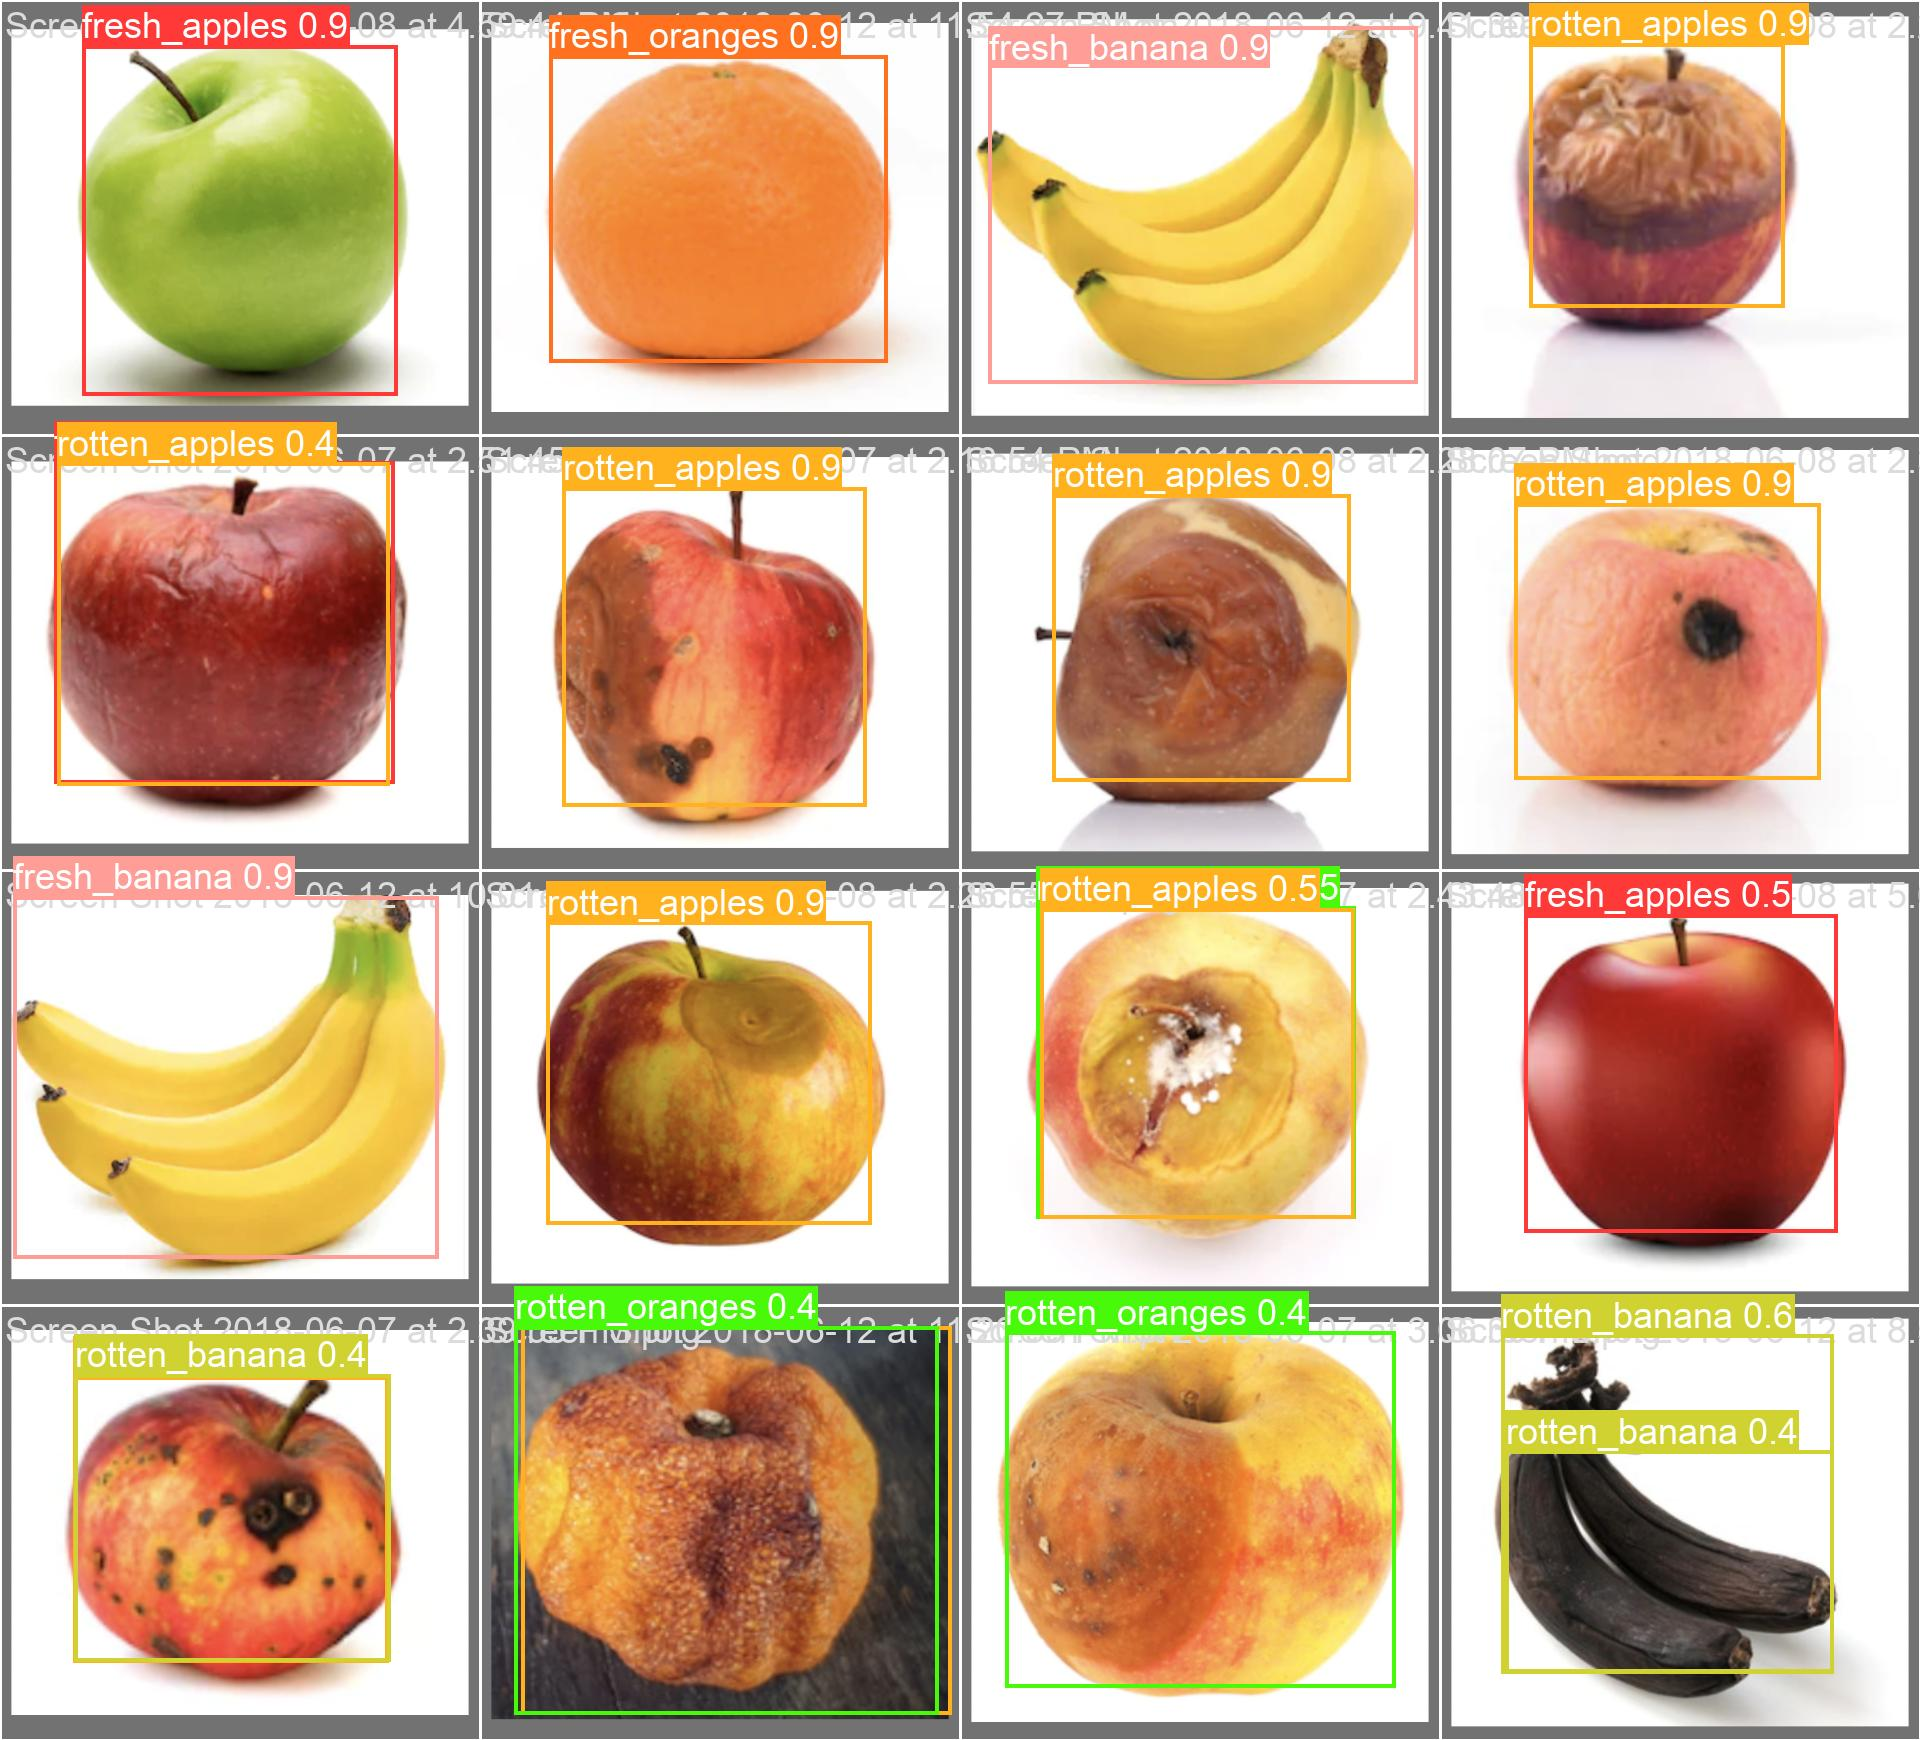

In [ ]:
Image(filename = '/content/runs/detect/val/val_batch2_pred.jpg')

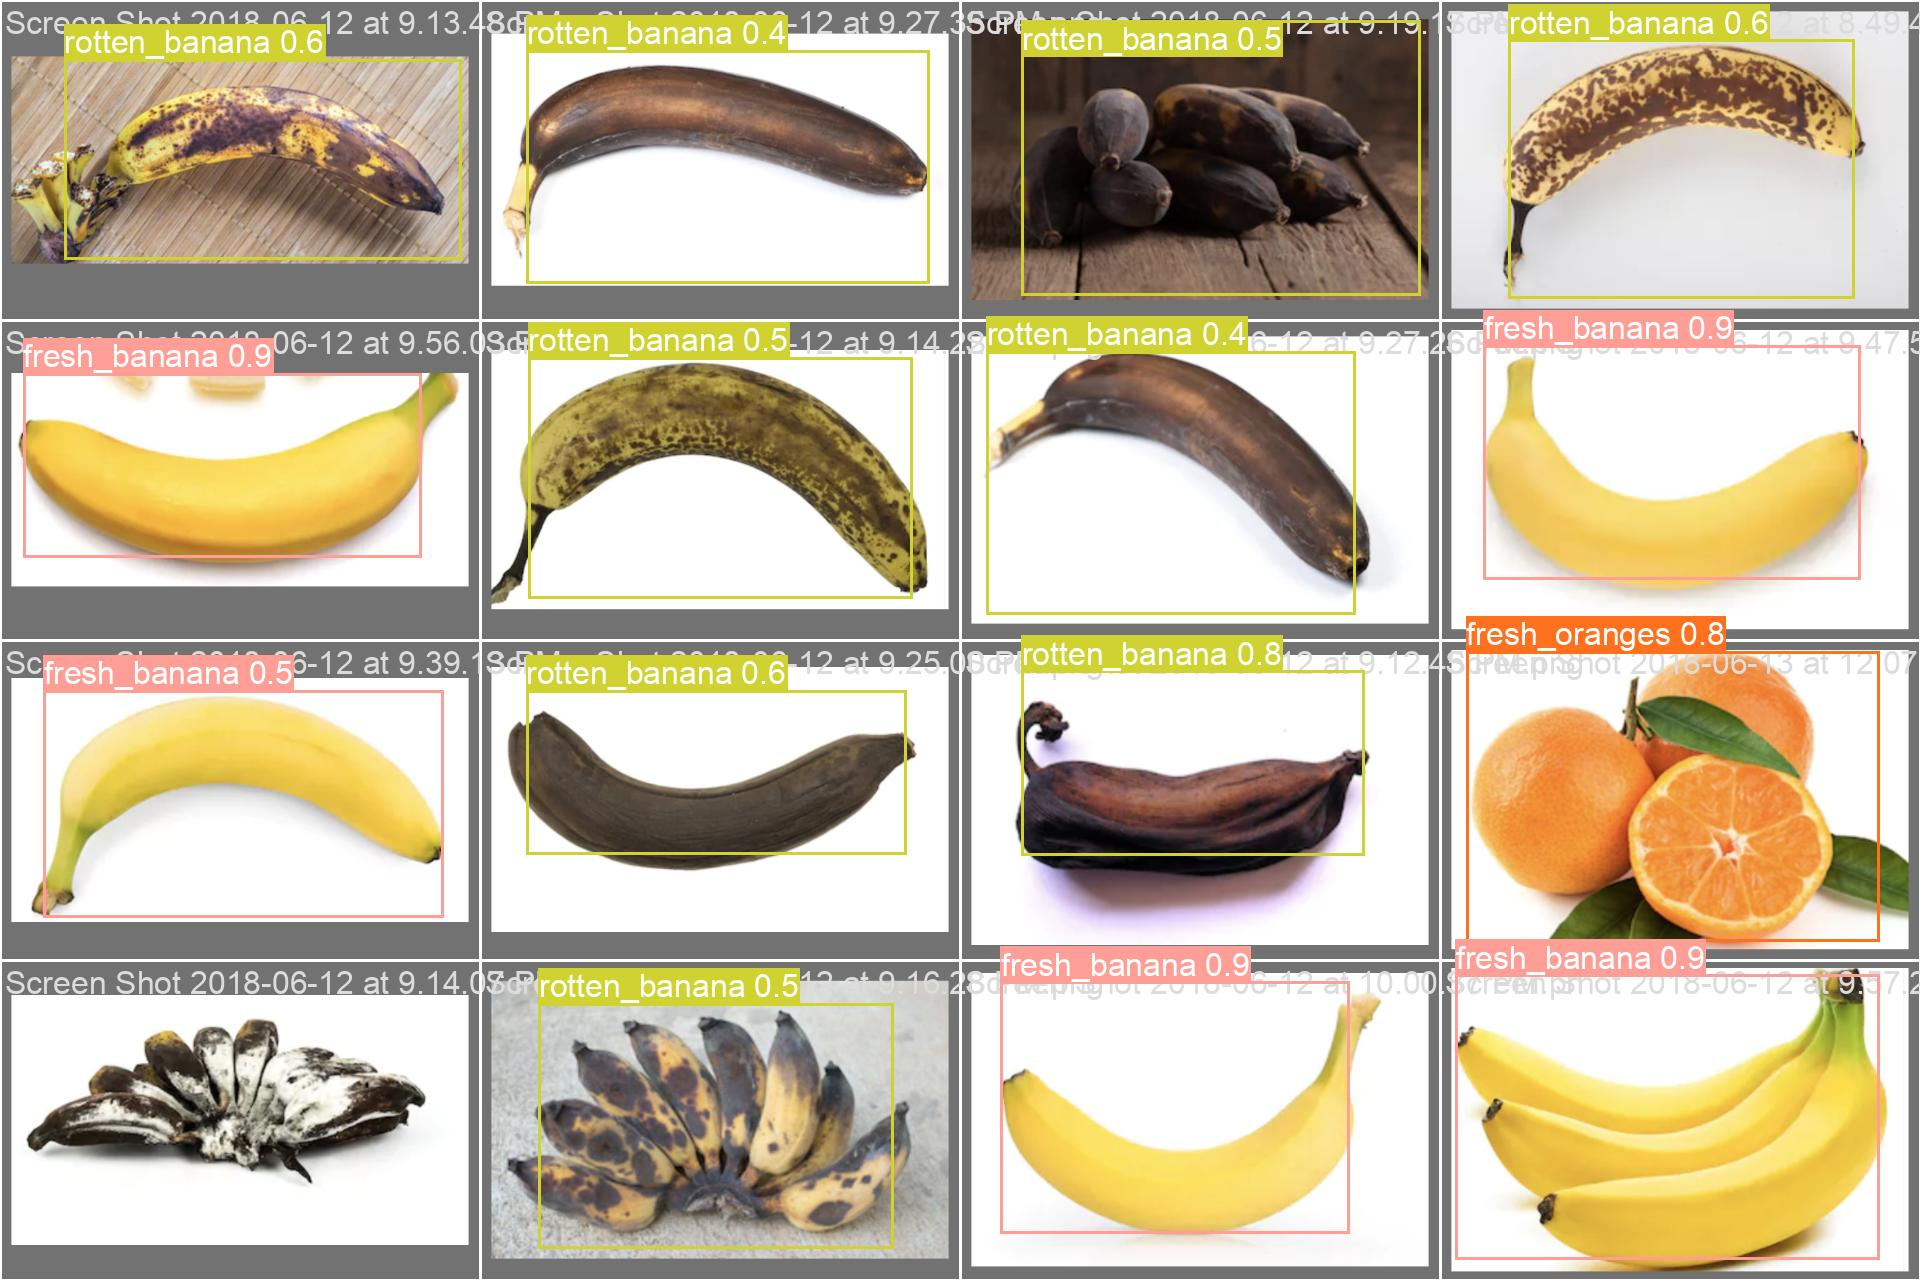

In [ ]:
Image(filename = '/content/runs/detect/val/val_batch0_pred.jpg')